In [1]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
from mido import MidiFile
import os

In [85]:
test_path = 'samples/music/motifs/'

files = os.listdir(test_path)
mpb = []
tpb = []
f_files = []
rolls = []
for f in files:
    note_found = False
    discard = False
    mpb_i = None
    mid_temp = MidiFile(os.path.join(test_path, f), clip=True)
    notes = {
        n: {'start': [], 'end': [], 'velocity': []}
        for n in range(128)
    }
    for msg in mid_temp.tracks[0]:
        if not msg.is_meta:
            if msg.type == 'note_on':
                if note_found:
                    t += msg.time
                else:
                    t = 0
                    note_found = True
                if msg.velocity > 0:
                    notes[msg.note]['start'].append(t // mid_temp.ticks_per_beat)
                    notes[msg.note]['velocity'].append(msg.velocity)
                else:
                    notes[msg.note]['end'].append(t // mid_temp.ticks_per_beat)
            if msg.type == 'note_off':
                t += msg.time
                notes[msg.note]['end'].append(t // mid_temp.ticks_per_beat)
        else:
            if msg.type == 'set_tempo':
                if mpb_i is None:
                    mpb_i = msg.tempo
                else:
                    discard = True
            elif msg.type == 'time_signature':
                if msg.numerator != 4 and  msg.denominator != 4:
                    print(msg)
    
    if not discard:
        f_files.append(f) 
        tpb.append(mid_temp.ticks_per_beat)
        mpb.append(mpb_i)
        piano_roll = np.zeros((128, t // mid_temp.ticks_per_beat))
        for n, events in notes.items():
            if len(events['start']) > 0:
                for n_ini, n_end, v in zip(events['start'], events['end'], events['velocity']):
                    piano_roll[n, n_ini:n_end] = v / 127
        rolls.append(piano_roll)

In [3]:
from datasets import MotifDataset
motif_size = 16
dataset = MotifDataset(motif_size=motif_size)

552 piano rolls loaded with [02, 13] - 7.216 ± 1.519


In [4]:
from models import MusicTransformer
from torch.utils.data import DataLoader


batch_size = 4

net = MusicTransformer([128, 128, 64, 64, 32])
n_param = sum(
    p.numel() for p in net.parameters() if p.requires_grad
)
print('Network ready {:d} parameters'.format(n_param))

train_loader = DataLoader(
    dataset, batch_size, True, num_workers=1
)
val_loader = DataLoader(
    dataset, batch_size, num_workers=1
)

# net.fit(train_loader, val_loader, epochs=10, patience=10)
net.load_model('weights/all.pt')

Network ready 387264 parameters


In [5]:
net.save_model('weights/all.pt')

In [ ]:
rand_idx = np.random.randint(0, len(rolls))
random_roll = rolls[rand_idx]
random_tpb = tpb[rand_idx]
random_motif = random_roll[:, :motif_size].astype(np.float32)
random_vel = np.mean(random_motif[random_motif > 0])
song = random_roll[:, :motif_size + 32] 
pred_song = net.song((random_motif > 0).astype(np.float32), 32)
print(np.max(pred_song, axis=0))
# plt.figure(figsize=(12, 12))
plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# sn.heatmap(song, cbar=False)
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.subplot(2, 1, 2)
final_song = np.concatenate([
    random_motif,
    random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
], axis=1)
sn.heatmap(final_song, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

[0.66141732 0.         0.59055118 0.59055118 0.59055118 0.
 0.         0.64566929 0.64566929 0.64566929 0.64566929 0.
 0.         0.         0.64566929 0.64566929 0.64566929 0.64566929
 0.64566929 0.         0.         0.         0.         0.
 0.62992126 0.62992126 0.62992126 0.62992126 0.62992126 0.62992126
 0.62992126 0.62992126]


<IPython.core.display.Javascript object>


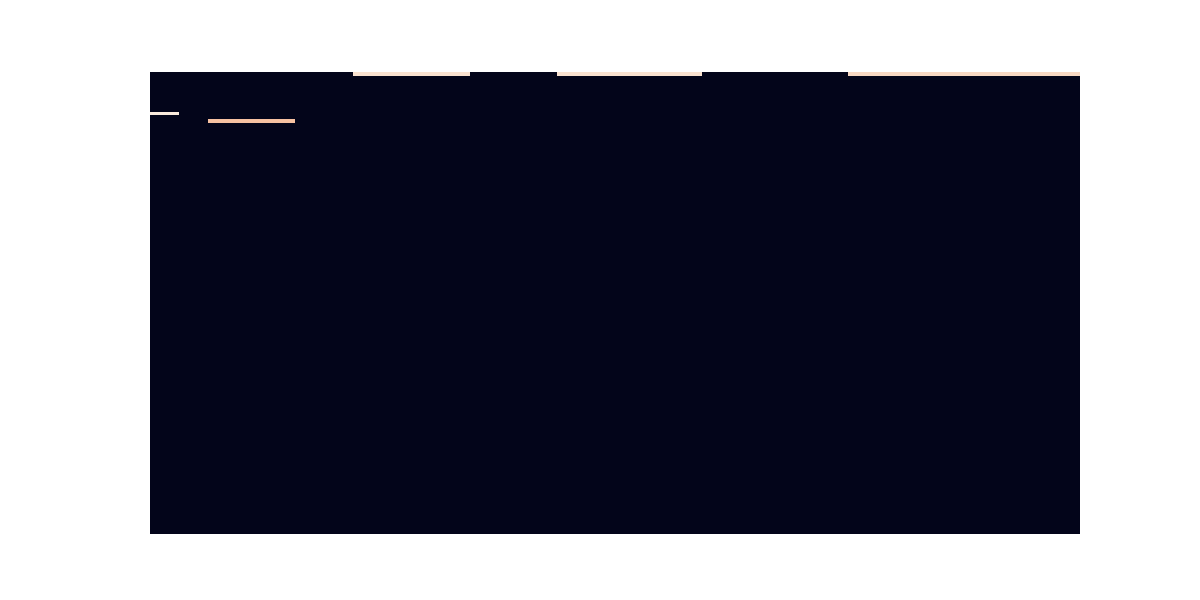

[]

In [83]:
rand_idx = np.random.randint(0, len(rolls))
random_roll = rolls[rand_idx]
random_tpb = tpb[rand_idx]
random_motif = random_roll[:, :motif_size].astype(np.float32)
random_vel = np.mean(random_motif[random_motif > 0])
song = random_roll[:, :motif_size + 32] 
# pred_song = net.song((random_motif > 0).astype(np.float32), 32)
# print(np.max(pred_song, axis=0))
print(np.max(random_roll, axis=0))
# plt.figure(figsize=(12, 12))
plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# sn.heatmap(song, cbar=False)
# plt.gca().set_xticks([])
# plt.gca().set_yticks([])
# plt.subplot(2, 1, 2)
# final_song = np.concatenate([
#     random_motif,
#     random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
# ], axis=1)
# sn.heatmap(final_song, cbar=False)
sn.heatmap(random_roll, cbar=False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])

In [89]:
from mido import Message, MetaMessage, MidiFile, MidiTrack

def roll_to_midi(path, name, roll, timing):
    mid = MidiFile()
    track = MidiTrack()
    mid.tracks.append(track)

    notes = []
    next_t = 0
    for beat in np.moveaxis(roll, 0, 1):
        beat_notes = np.where(np.squeeze(beat) > 0)[0]
        if len(beat_notes) > 0:
            for note in beat_notes:
                if not (note in notes):
                    track.append(Message(
                        'note_on', time=next_t * timing, note=note, 
                        velocity=int(np.squeeze(beat)[note] * 127)))
                    print('Note on', note, int(np.squeeze(beat)[note] * 127), next_t * timing
                         )
                    notes.append(note)
                    next_t = 0
            for note in notes:
                if not (note in beat_notes):
                    track.append(Message('note_on', time=next_t * timing, note=note, velocity=0))
                    print('Note off', note)
                    next_t = 0
            notes = beat_notes.tolist()
        else:
            for note in notes:
                track.append(Message('note_on', time=next_t * timing, note=note, velocity=0))
                print('Note off', note, next_t * timing)
            notes = []
        next_t += 1
    mid.save(os.path.join(path, name))

    
for i in range(10):
    rand_idx = np.random.randint(0, len(rolls))
    random_roll = rolls[rand_idx]
    random_tpb = tpb[rand_idx]
    random_motif = random_roll[:, :motif_size].astype(np.float32)
    random_vel = np.mean(random_motif[random_motif > 0])
    song = random_roll[:, :motif_size + 32] 
    pred_song = net.song((random_motif > 0).astype(np.float32), 128)
#     final_song = np.concatenate([
#         random_motif,
#         random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
#     ], axis=1)
    final_song = random_vel * pred_song[:, motif_size:] * (pred_song[:, motif_size:] > 0.75)
    roll_to_midi('samples/music/', 'test{:02d}.mid'.format(i), final_song, random_tpb)
    roll_to_midi('samples/music/', 'test_init{:02d}.mid'.format(i), random_roll, random_tpb)

Note on 67 90 0
Note on 56 90 480
Note off 67
Note on 55 90 480
Note on 74 68 0
Note off 56
Note on 60 90 480
Note on 63 89 0
Note off 55
Note off 74
Note on 58 90 480
Note off 60
Note off 63
Note on 63 90 480
Note off 58
Note on 56 75 960
Note on 67 83 0
Note on 74 67 0
Note on 68 86 480
Note off 56
Note off 67
Note on 60 90 480
Note off 63
Note off 68
Note off 74
Note on 57 74 480
Note on 62 90 0
Note on 64 72 0
Note off 60
Note on 60 90 480
Note off 57
Note off 62
Note off 64
Note on 63 70 480
Note on 67 90 480
Note off 60
Note off 63
Note on 60 90 480
Note on 86 79 0
Note off 67
Note on 58 90 480
Note off 60
Note off 86
Note on 55 90 480
Note on 63 88 0
Note on 69 80 0
Note on 71 70 0
Note off 58
Note on 58 90 480
Note on 72 79 0
Note off 55
Note off 63
Note off 69
Note off 71
Note on 62 90 480
Note off 58
Note off 72
Note on 69 90 480
Note off 62
Note on 53 90 480
Note on 55 82 0
Note on 60 88 0
Note on 61 73 0
Note off 69
Note on 58 90 480
Note on 63 70 0
Note on 65 87 0
Note on 

Note on 56 77 0
Note on 59 83 0
Note on 60 70 0
Note on 62 85 0
Note on 63 69 0
Note on 72 80 0
Note on 65 85 480
Note off 56
Note off 59
Note off 60
Note off 62
Note off 63
Note off 72
Note on 63 85 480
Note off 65
Note on 55 85 480
Note on 58 73 0
Note off 63
Note on 62 85 480
Note off 55
Note off 58
Note on 56 85 480
Note off 62
Note on 75 85 480
Note on 62 77 480
Note on 63 85 0
Note off 56
Note off 75
Note on 53 76 480
Note on 56 85 0
Note on 67 74 0
Note off 62
Note off 63
Note on 63 85 480
Note off 53
Note off 56
Note off 67
Note on 65 85 480
Note off 63
Note on 57 85 480
Note off 65
Note on 63 85 480
Note off 57
Note on 58 71 480
Note on 57 68 480
Note on 64 85 0
Note off 58
Note off 63
Note on 60 81 480
Note on 67 85 0
Note off 57
Note off 64
Note on 62 85 480
Note off 60
Note off 67
Note on 48 73 480
Note on 65 85 0
Note on 67 74 0
Note off 62
Note on 60 85 480
Note off 48
Note off 67
Note on 63 85 480
Note off 60
Note off 65
Note on 53 68 480
Note on 60 66 0
Note on 67 85 0


Note on 59 91 0
Note on 60 79 0
Note on 56 91 480
Note off 59
Note off 60
Note on 55 91 480
Note off 56
Note on 61 91 480
Note on 62 91 0
Note on 72 69 0
Note off 55
Note on 56 91 480
Note off 61
Note off 62
Note off 72
Note on 58 70 480
Note on 60 91 0
Note on 63 91 480
Note off 56
Note off 58
Note off 60
Note on 56 91 480
Note on 58 69 0
Note on 62 91 0
Note on 67 69 0
Note off 63
Note on 55 91 480
Note off 56
Note off 58
Note off 62
Note off 67
Note on 60 91 480
Note off 55
Note on 61 81 480
Note on 62 91 0
Note off 60
Note on 60 91 480
Note on 67 91 0
Note on 71 76 0
Note off 61
Note off 60
Note off 67
Note off 71
Note on 64 91 480
Note off 62
Note on 56 91 960
Note on 60 90 0
Note on 62 71 0
Note on 65 69 0
Note off 64
Note on 63 70 480
Note on 67 88 0
Note off 60
Note off 62
Note on 60 69 480
Note off 63
Note off 65
Note off 67
Note on 65 91 480
Note off 56
Note off 60
Note on 53 91 480
Note off 65
Note on 57 84 480
Note on 64 91 0
Note off 53
Note on 63 91 480
Note off 57
Note o

Note on 57 78 0
Note on 67 102 0
Note on 74 87 0
Note on 69 102 480
Note off 57
Note off 67
Note off 74
Note on 62 102 480
Note on 63 77 0
Note on 76 80 0
Note off 69
Note on 55 102 480
Note off 62
Note off 63
Note off 76
Note on 56 102 480
Note off 55
Note on 53 102 480
Note on 63 88 0
Note on 65 93 480
Note on 67 85 0
Note off 53
Note on 60 97 480
Note on 62 80 0
Note off 56
Note off 63
Note off 65
Note off 60
Note off 62
Note on 58 102 480
Note off 67
Note on 56 90 480
Note on 62 101 0
Note off 56
Note off 62
Note on 63 102 480
Note off 58
Note on 65 102 480
Note off 63
Note on 67 101 480
Note on 71 102 0
Note off 65
Note on 55 84 480
Note on 58 102 0
Note off 67
Note off 71
Note on 57 102 480
Note on 61 83 0
Note on 64 77 0
Note off 55
Note on 55 83 480
Note on 60 102 0
Note on 76 94 0
Note off 57
Note off 58
Note off 61
Note off 64
Note on 58 102 480
Note off 55
Note off 60
Note off 76
Note on 59 96 480
Note on 63 99 0
Note on 69 102 0
Note off 58
Note on 55 79 480
Note on 60 102 

Note on 56 90 0
Note on 64 101 0
Note on 65 77 0
Note off 64
Note off 65
Note on 58 101 480
Note off 56
Note on 56 84 480
Note on 63 101 0
Note on 67 89 0
Note off 58
Note on 55 101 480
Note off 56
Note off 63
Note off 67
Note on 56 101 480
Note on 58 93 0
Note off 55
Note on 63 101 480
Note off 56
Note off 58
Note on 62 101 480
Note off 63
Note on 57 93 960
Note on 60 101 0
Note off 62
Note on 63 101 480
Note off 57
Note off 60
Note on 58 101 480
Note on 67 87 0
Note off 63
Note on 60 101 480
Note off 58
Note off 67
Note on 56 101 480
Note off 60
Note on 67 101 480
Note off 56
Note on 63 86 480
Note on 56 101 480
Note on 60 76 0
Note on 62 77 0
Note on 65 79 0
Note on 69 80 0
Note off 63
Note off 67
Note on 55 101 480
Note on 58 78 0
Note off 56
Note off 60
Note off 62
Note off 65
Note off 69
Note on 67 101 480
Note off 55
Note off 58
Note on 58 101 480
Note off 67
Note on 59 84 480
Note on 67 79 0
Note on 74 101 0
Note off 58
Note on 53 101 480
Note off 59
Note off 67
Note off 74
Not